# Comparing Scores for tigge, deterministic, parametric, test-time dropout, categorical models

Todo
- run scripts for MC dropout
- in parametric, std values negative in 0.01% cases. ->make them zero.
- in categorical, 
    - instead of mean=sigma(xP), try sampling to find scores
    - see why quantile binning giving worse results than uniform
    - check if making first, last bin_edges uniform increases score.(minor thing.may skip)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.networks import *
from src.score import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
#if model was trained on mixed precision policy, loading on the same policy necessary? Yes. see verbose results of model.predict
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [5]:
# model_save_dir='/home/garg/data/WeatherBench/predictions_P/saved_models'
# datadir='/home/garg/data/WeatherBench/5.625deg'
# pred_save_dir='/home/garg/data/WeatherBench/predictions_P'
model_save_dir='/home/rasp/data/myWeatherBench/predictions_P/saved_models/'
datadir='/data/stephan/WeatherBench/5.625deg/'
pred_save_dir='/home/rasp/data/myWeatherBench/predictions_P/'


In [6]:
#Parameters
lead_time=72
members=50

In [7]:
!ls $pred_save_dir

001-resnet_d3_ztt_3d_dr0.0_m50.nc  009-resnet_d3_tp_3d_cat.nc
001-resnet_d3_ztt_3d_dr0.0.nc	   010-resnet_d3_z_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2_m50.nc  011-resnet_d3_t_3d_cat_quant.nc
003-resnet_d3_ztt_3d_dr0.2.nc	   012-resnet_d3_t2m_3d_cat_quant.nc
004-resnet_d3_ztt_3d_dr0.5_m50.nc  013-resnet_d3_tp_3d_cat_quant.nc
004-resnet_d3_ztt_3d_dr0.5_m5.nc   017-resnet_d3_ztt_3d_m50.nc
004-resnet_d3_ztt_3d_dr0.5.nc	   020-resnet_d3_tp_3d_dr0.0_m50.nc
005.1-resnet_d3_ztt_3d_param.nc    020-resnet_d3_tp_3d_dr0.0.nc
005-resnet_d3_ztt_3d_param.nc	   021-resnet_d3_tp_3d_dr0.2_m50.nc
006.1-resnet_d3_z_3d_cat.nc	   021-resnet_d3_tp_3d_dr0.2.nc
006-resnet_d3_z_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m50.nc
007.1-resnet_d3_t_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5_m5.nc
0078resnet_d3_t2m_3d_cat.nc	   022-resnet_d3_tp_3d_dr0.5.nc
007-resnet_d3_t_3d_cat.nc	   054-resnet_d3_tp_3d_m50.nc
008.1-resnet_d3_t2m_3d_cat.nc	   saved_models


## Data

In [8]:
!ls {datadir}

24hr_precipitation    geopotential	   temperature_850
2m_temperature	      geopotential_500	   toa_incident_solar_radiation
2m_temperature_daily  potential_vorticity  total_precipitation
6hr_precipitation     specific_humidity    u_component_of_wind
constants	      temperature	   v_component_of_wind


In [9]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z').drop('level')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't').drop('level')
t2m_valid = xr.open_mfdataset(f'{datadir}/2m_temperature/*.nc',combine='by_coords')
tp_valid=xr.open_mfdataset(f'{datadir}/6hr_precipitation/*.nc',combine='by_coords')

# SR: Not necessary because we never look at other levels
ztt_valid=xr.merge([z500_valid,t850_valid, t2m_valid])  #.rename({'z':'z_500', 't':'t_850'})
valid=xr.merge([ztt_valid, tp_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(341880, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

## TIGGE - Precip still missing

In [10]:
tigge_dir = '/mnt/netdisk1/stephan/WeatherBench/tigge/5.625deg/'

In [11]:
!ls $tigge_dir

2m_temperature_ens    temperature_850	   total_precipitation_ens
geopotential_500      temperature_850_ens  total_precipitation_ens_old
geopotential_500_ens  total_precipitation


In [12]:
tigge_z = xr.open_mfdataset(f'{tigge_dir}geopotential_500_ens/*nc')
tigge_t = xr.open_mfdataset(f'{tigge_dir}temperature_850_ens/*nc')
tigge_t2m = xr.open_mfdataset(f'{tigge_dir}2m_temperature_ens/*nc')
tigge_tp = xr.open_mfdataset(f'{tigge_dir}total_precipitation_ens/*nc')

In [13]:
# Covert to ERA convention
tigge_z *= 9.806

In [14]:
tigge_tp

<xarray.Dataset>
Dimensions:     (lat: 32, lon: 64, number: 50, step: 29, time: 424)
Coordinates:
    surface     int64 0
  * lat         (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * step        (step) timedelta64[ns] 0 days 00:00:00 ... 7 days 00:00:00
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * lon         (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time        (time) datetime64[ns] 2017-01-01 ... 2017-07-31T12:00:00
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(62, 29), meta=np.ndarray>
Data variables:
    tp          (number, time, step, lat, lon) float32 dask.array<chunksize=(50, 62, 29, 32, 64), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-11-01T09:43:44 GRIB to CDM+CF via cfgrib-0....

In [21]:
tigge_tp = tigge_tp.diff('step') / 1000.

In [22]:
tigge = xr.merge([tigge_z, tigge_t, tigge_t2m, tigge_tp], compat="override")

In [23]:
tigge = tigge.rename({'number': 'member', 'gh':'z'})
tigge = tigge.sel(step='3 days')
tigge['time'] = tigge['valid_time']

In [24]:
tigge = tigge.sel(time=slice('2017', '2018'))

In [25]:
tigge.load()

<xarray.Dataset>
Dimensions:            (lat: 32, lon: 64, member: 50, time: 1454)
Coordinates:
    step               timedelta64[ns] 3 days
  * time               (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
    isobaricInhPa      int64 500
  * lat                (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon                (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
    valid_time         (time) datetime64[ns] 2017-01-04 ... 2018-12-31T12:00:00
  * member             (member) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  (member, time, lat, lon) float32 51355.71 ... 48772.332
    t                  (member, time, lat, lon) float32 258.87042 ... 248.53922
    t2m                (member, time, lat, lon) float32 246.63593 ... 248.03877
    tp                 (member, time, lat, lon) float32 0.0 0.0 0.0 ... nan nan

### RMSE of ensemble mean

In [26]:
tigge_rmse = compute_weighted_rmse(tigge.mean('member'), valid).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
tigge_rmse

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    isobaricInhPa      int64 500
    step               timedelta64[ns] 3 days
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  float64 144.8
    t                  float64 1.201
    t2m                float64 1.257
    tp                 float64 0.002023

In [41]:
tigge_rmse.to_netcdf('tmp/tigge_rmse.nc')

### Spread-skill

In [29]:
tigge_spreadskill=compute_weighted_meanspread(tigge)/tigge_rmse
tigge_spreadskill

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  float64 1.051
    t                  float64 0.9288
    t2m                float64 0.6881
    tp                 float64 0.8439

In [40]:
tigge_spreadskill.to_netcdf('tmp/tigge_spreadskill.nc')

### CRPS

In [31]:
tigge_crps=compute_weighted_crps(tigge, valid.sel(time=tigge.time))
tigge_crps.load()

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    step               timedelta64[ns] 3 days
    isobaricInhPa      int64 500
    heightAboveGround  int64 2
    surface            int64 0
Data variables:
    z                  float64 65.6
    t                  float64 0.5994
    t2m                float64 0.5755
    tp                 float64 0.0004088

In [39]:
tigge_crps.to_netcdf('tmp/tigge_crps.load.nc')

### Rank histogram

In [33]:
from ranky import rankz
from scipy.stats import rankdata
import pdb

def rankz_weighted(obs, ensemble, weights_lat, density=False):
    shape = obs.shape
    obs = obs.reshape(-1)
    ensemble = ensemble.reshape(ensemble.shape[0], -1)
    
    combined=np.vstack((obs[np.newaxis],ensemble))
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)
    
    #ToDo: not sure if this ties-part works for ndarray. but minor thing.
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    has_tie = np.argwhere(ties > 0).squeeze()

    for i in has_tie:
#         print('Tie', ranks[i], ensemble[:, i], obs[i])
        min_rank = ranks[i]
        max_rank = ranks[i] + ties[i]
        ranks[i] = np.random.randint(min_rank, max_rank)
    
    ranks = ranks.reshape(shape)
    
    weights=np.ones(ranks.shape)
    weights=weights*weights_lat[np.newaxis,:,np.newaxis]

    return np.histogram(ranks, bins=np.linspace(0.5, combined.shape[0]+0.5, combined.shape[0]+1),
                       weights=weights, density=density)

In [34]:
weights_lat = np.cos(np.deg2rad(valid.lat))
weights_lat /= weights_lat.mean()

In [35]:
ranks = {}
for v in tigge:
    print(v)
    time = tigge.time
    p = tigge[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)

    ranks[v] = rank

z
t
t2m
tp


In [36]:
with open(f'tmp/tigge_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

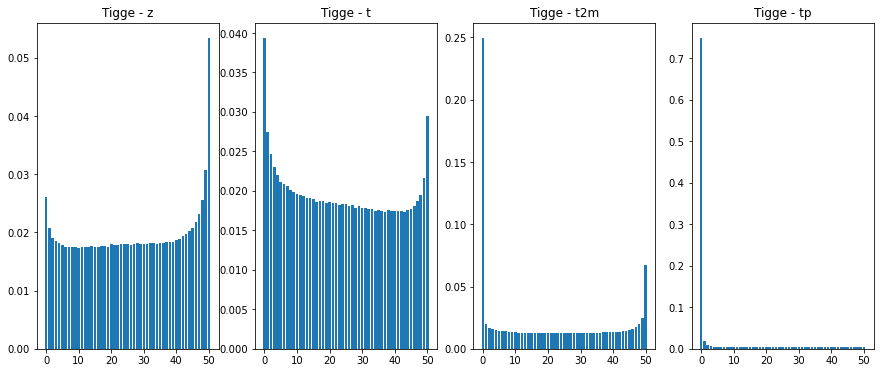

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Tigge - {v}')

Uncalibrated, probably simple bias.

## Monte-carlo dropout

In [10]:
pred_save_dir_dr='/home/rasp/data/myWeatherBench/predictions_'

mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'C/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'C/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

### Load and evaluate no-dropout predictions

In [ ]:
rmses, maes = [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+'.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+'.nc')
    preds = xr.merge([preds_ztt, preds_tp]).isel(time=slice(0, None, 12))
    rmse = compute_weighted_rmse(preds, valid).load()
    rmses.append(rmse)
    mae = compute_weighted_mae(preds, valid).load()
    maes.append(mae)

In [ ]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
rmses

In [ ]:
rmses.to_netcdf('tmp/dropout_det_rmse.nc')
maes.to_netcdf('tmp/dropout_det_mae.nc')

In [10]:
rmses = xr.open_dataset('tmp/dropout_det_rmse.nc')

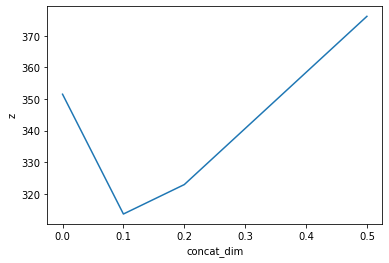

In [11]:
rmses.z.plot();

### Create 50 member dropout predictions

SR: Only predicting every 12th time step. Makes very little difference for score and is 12 times faster. You should be able to do this on PC as well. For me this takes around 4 minutes.

Note: Manually change P to C for 0.1 exps.

In [52]:
ss = ''
for e in mc_exp_ids_ztt:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && '
#     print(s)
    ss += s
print(ss)

python create_dropout_ensemble.py  50  ../nn_configs/P/001-resnet_d3_ztt_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/C/017-resnet_d3_ztt_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/003-resnet_d3_ztt_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 3 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/004-resnet_d3_ztt_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBenc

In [54]:
ss = ''
for e in mc_exp_ids_tp:
    s = f'python create_dropout_ensemble.py  50  ../nn_configs/{e}.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && '
#     print(s)
    ss += s
print(ss)

python create_dropout_ensemble.py  50  ../nn_configs/P/020-resnet_d3_tp_3d_dr0.0.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/C/054-resnet_d3_tp_3d.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/021-resnet_d3_tp_3d_dr0.2.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/predictions_P/ --gpu 4 --data_subsample 6 --dt 1 && python create_dropout_ensemble.py  50  ../nn_configs/P/022-resnet_d3_tp_3d_dr0.5.yml /data/stephan/WeatherBench/5.625deg/ /home/rasp/data/myWeatherBench/predictions_P/saved_models/ /home/rasp/data/myWeatherBench/pr

### Compute RMSE of ensemble mean and spread/skill and CRPS

In [55]:
members = 50

In [56]:
mc_exp_ids_ztt = [
    'P/001-resnet_d3_ztt_3d_dr0.0',
    'P/017-resnet_d3_ztt_3d',
    'P/003-resnet_d3_ztt_3d_dr0.2',
    'P/004-resnet_d3_ztt_3d_dr0.5',
]

mc_exp_ids_tp = [
    'P/020-resnet_d3_tp_3d_dr0.0',
    'P/054-resnet_d3_tp_3d',
    'P/021-resnet_d3_tp_3d_dr0.2',
    'P/022-resnet_d3_tp_3d_dr0.5',
]

In [57]:
rmses, maes, crpss, spread_skills = [], [], [], []
for i, dr in tqdm(enumerate([0, 0.1, 0.2, 0.5])):
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    ens_mean = preds.mean('member')
    rmse = compute_weighted_rmse(ens_mean, valid).load()
    mae = compute_weighted_mae(ens_mean, valid).load()
    crps = compute_weighted_crps(preds, valid).load()
    spread = compute_weighted_meanspread(preds).load()
    rmses.append(rmse)
    maes.append(mae)
    crpss.append(crps)
    spread_skills.append(spread / rmse)

4it [02:40, 40.05s/it]


In [58]:
rmses = xr.concat(rmses, dim=[0, 0.1, 0.2, 0.5])
maes = xr.concat(maes, dim=[0, 0.1, 0.2, 0.5])
crpss = xr.concat(crpss, dim=[0, 0.1, 0.2, 0.5])
spread_skills = xr.concat(spread_skills, dim=[0, 0.1, 0.2, 0.5])

In [59]:
rmses.to_netcdf('tmp/dropout_rmse.nc')
maes.to_netcdf('tmp/dropout_mae.nc')
crpss.to_netcdf('tmp/dropout_crps.nc')
spread_skills.to_netcdf('tmp/dropout_spreadskill.nc')

In [60]:
rmses = xr.open_dataset('tmp/dropout_rmse.nc')
maes = xr.open_dataset('tmp/dropout_mae.nc')
crpss = xr.open_dataset('tmp/dropout_crps.nc')
spread_skills = xr.open_dataset('tmp/dropout_spreadskill.nc')

In [64]:
rmses_det = xr.open_dataset('tmp/dropout_det_rmse.nc')

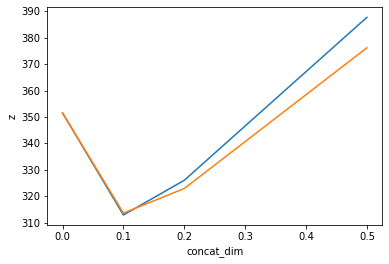

In [65]:
rmses.z.plot();
rmses_det.z.plot();

In [62]:
crpss[['z', 't', 't2m', 'tp']].isel(concat_dim=3).load()

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    concat_dim  float64 0.5
Data variables:
    z           float64 193.7
    t           float64 1.197
    t2m         float64 0.9013
    tp          float64 0.0005988

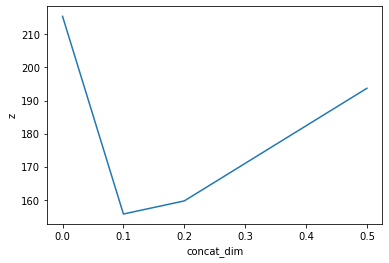

In [63]:
crpss.z.plot()

### Rank histogram

In [69]:
ranks = {}
for i, dr in tqdm(enumerate([0.1, 0.2, 0.5])):
    ranks[dr] = {}
    print(dr)
    preds_ztt = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_ztt[i+1]+f'_m{members}.nc')
    preds_tp = xr.open_dataset(pred_save_dir_dr+mc_exp_ids_tp[i+1]+f'_m{members}.nc')
    preds = xr.merge([preds_ztt, preds_tp])
    for v in preds:
        print(v)
        time = preds.time
        p = preds[v].sel(time=time)
        o = valid[v].sel(time=time).load()
        rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
        ranks[dr][v] = rank

0it [00:00, ?it/s]

0.1
t
t2m
z
tp


1it [14:49, 889.18s/it]

0.2
z
t
t2m
tp


2it [29:52, 893.42s/it]

0.5
z
t2m
t
tp


3it [44:57, 899.09s/it]


In [70]:
with open(f'tmp/dropout_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

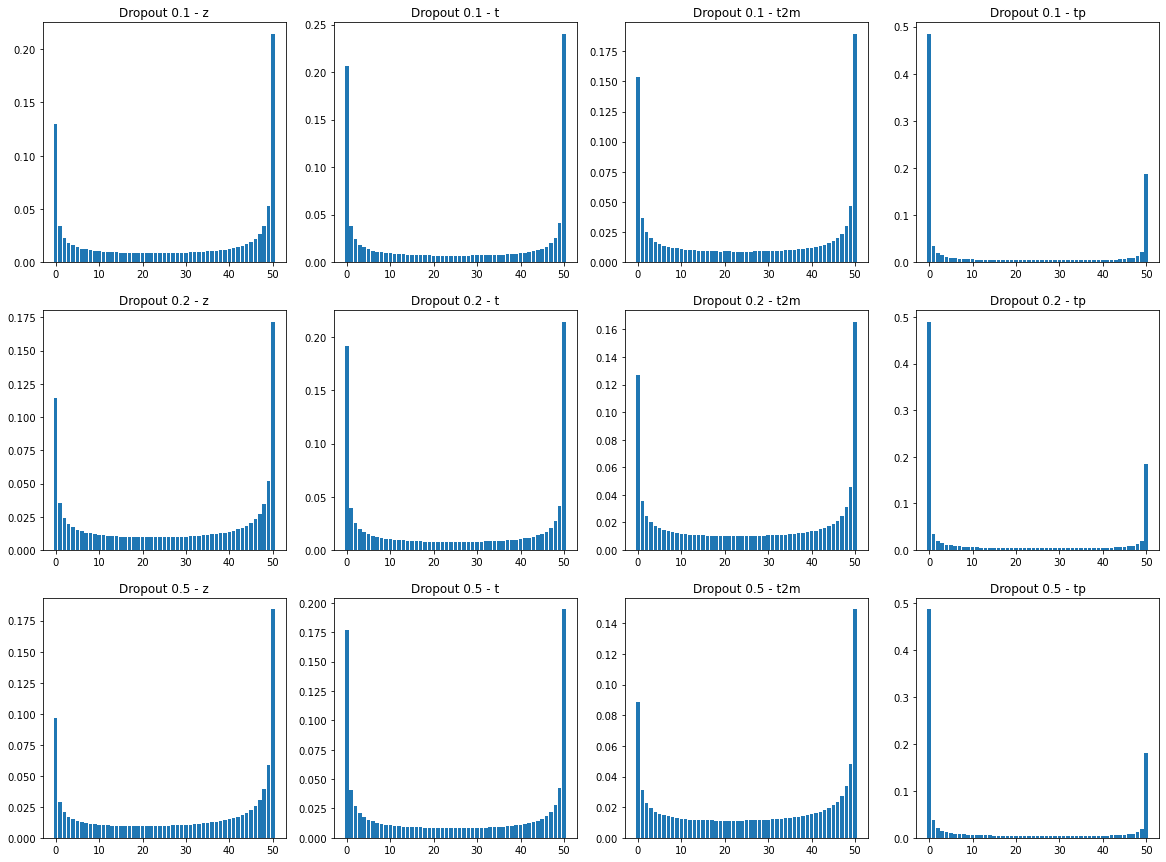

In [71]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
for i, dr in enumerate([0.1, 0.2, 0.5]):
    for j, v in enumerate(['z', 't', 't2m', 'tp']):
        r = ranks[dr][v]
        axs[i, j].bar(np.arange(51), r[0])
        axs[i, j].set_title(f'Dropout {dr} - {v}')

## Parametric - tp missing

In [ ]:
preds_ztt = xr.open_dataset(f'{pred_save_dir}/005.1-resnet_d3_ztt_3d_param.nc')

In [ ]:
preds_ztt_mean=preds_ztt[['z-mean','t-mean','t2m-mean']].rename({'z-mean':'z','t-mean':'t','t2m-mean':'t2m'})
preds_ztt_std=preds_ztt[['z-std','t-std','t2m-std']].rename({'z-std':'z','t-std':'t','t2m-std':'t2m'})

In [ ]:
preds_ztt_std = preds_ztt_std.where(preds_ztt_std>0, 1e-7)  # To avoid division by zero in CRPS

### RMSE of ensemble mean

In [ ]:
rmse = compute_weighted_rmse(preds_ztt_mean, valid).compute()
rmse

In [ ]:
rmse.to_netcdf('tmp/parametric_rmse.nc')

### Spread skill

In [ ]:
var = preds_ztt_std**2

In [ ]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [ ]:
spread= np.sqrt((var*weights_lat).mean())

In [ ]:
spread_skill = spread / rmse

In [ ]:
spread_skill

In [ ]:
spread_skill.to_netcdf('tmp/parametric_spreadskill.nc')

### CRPS

In [ ]:
def compute_weighted_crps_gaussian(obs, mean, std,mean_dims=xr.ALL_DIMS):
    weights_lat = np.cos(np.deg2rad(obs.lat)).values
    weights_lat /= weights_lat.mean()
    crps = xs.crps_gaussian(obs,mean,std)
    crps = (crps * weights_lat[: , None, None]).mean(mean_dims)
    return crps

In [ ]:
crps = compute_weighted_crps_gaussian(valid.isel(time=slice(0, None, 12))[['z', 't', 't2m']], preds_ztt_mean, preds_ztt_std).load()
crps

In [ ]:
crps.to_netcdf('tmp/parametric_crps.nc')

### Rank histogram

In [ ]:
members

In [ ]:
das = []
for v in preds_ztt_mean:
    da = xr.DataArray(
        np.random.normal(
            preds_ztt_mean[v].values, 
            preds_ztt_std[v].values,
            size=(members, *preds_ztt_mean[v].shape)
        ),
        coords={
            'member': np.arange(members),
            'time': preds_ztt_mean.time,
            'lat': preds_ztt_mean.lat, 
            'lon': preds_ztt_mean.lon,}, 
        dims=['member','time','lat', 'lon'],
        name=v
    )
    das.append(da)
preds_ztt_ens = xr.merge(das)

In [ ]:
preds_ztt_ens.to_netcdf('tmp/preds_param_ztt_ens.nc')

In [ ]:
preds_ztt_ens = xr.open_dataset('tmp/preds_param_ztt_ens.nc')

In [ ]:
ranks = {}
for v in preds_ztt_ens:
    print(v)
    time = preds_ztt_ens.time
    p = preds_ztt_ens[v].sel(time=time)
    o = valid[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

In [ ]:
with open(f'tmp/parametric_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
for j, v in enumerate(['z', 't', 't2m']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Parametric - {v}')

## Categorical

In [ ]:
valid_diff = (valid.shift() -  valid.shift(time=lead_time)).isel(time=slice(0, None, 12))

In [ ]:
valid_diff['tp'] = valid['tp']

In [ ]:
valid_diff

In [ ]:
valid_diff['tp'] = np.maximum(0, valid_diff.tp)

In [ ]:
preds_cat = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/006.1-resnet_d3_z_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/007.1-resnet_d3_t_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/008.1-resnet_d3_t2m_3d_cat.nc'),
    xr.open_dataset(f'{pred_save_dir}/009-resnet_d3_tp_3d_cat.nc'),
]).isel(time=slice(0, None, 12))

In [ ]:
preds_cat

In [ ]:
time = '2017-01-04T12:00:00'
preds_cat.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [ ]:
def log_retrans(x, e):
    return np.exp(x + np.log(e)) - e

In [ ]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m']:
    preds_cat[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2

v='tp'
preds_cat[v].bin_edges[:] = log_retrans(preds_cat[v].bin_edges, 0.001)
preds_cat[v].bin_edges[0] = 0
preds_cat[v].bin_edges[-1] = valid[v].max().values
preds_cat[v].mid_points[:] = (preds_cat[v].bin_edges[1:] +  preds_cat[v].bin_edges[:-1])/2
preds_cat[v].mid_points[0] = 0

### RMSE of mean

In [ ]:
means = []
for v in preds_cat:
    means.append((preds_cat[v] * preds_cat[v].mid_points).sum('bin'))
means = xr.merge(means)

In [ ]:
rmse_cat = compute_weighted_rmse(means, valid_diff).load()

In [ ]:
rmse_cat

In [ ]:
rmse_cat.to_netcdf('tmp/categorical_rmse.nc')

### Spread/skill ratio

In [ ]:
#Spread=squareroot( ∑((x−μ)^2)P(x)) or E[x^2]-(E[x])^2
meansquares = []
for v in preds_cat:
    meansquares.append((preds_cat[v] * preds_cat[v].mid_points**2).sum('bin'))
meansquares = xr.merge(meansquares)

In [ ]:
var = meansquares - means**2

In [ ]:
weights_lat = np.cos(np.deg2rad(var.lat))
weights_lat /= weights_lat.mean()

In [ ]:
spread = np.sqrt((var*weights_lat).mean())

In [ ]:
spread_skill = spread / rmse_cat

In [ ]:
spread_skill

In [ ]:
spread_skill.to_netcdf('tmp/categorical_spreadskill.nc')

### CRPS

In [ ]:
crps = compute_weighted_bin_crps(preds_cat, valid_diff)

In [ ]:
crps

In [ ]:
crps.to_netcdf('tmp/categorical_crps.nc')

### Rank histogram

In [ ]:
time = preds_cat.time

In [ ]:
def rand_choice(p, mid_points=None):
    p = p / p.sum()
    return np.random.choice(mid_points, size=1, p=p, replace=True)

In [ ]:
das = []
for v in preds_cat:
    da = preds_cat[v].sel(time=time)
    da = xr.concat([xr.apply_ufunc(
        rand_choice, da, kwargs={'mid_points': da.mid_points}, input_core_dims=[['bin']], vectorize=True
    )  for i in range(members)], 'member')
    das.append(da)
preds_cat_ens = xr.merge(das)

In [ ]:
preds_cat_ens

In [ ]:
preds_cat_ens.to_netcdf('tmp/preds_cat_ens.nc')

In [ ]:
ranks = {}
for v in preds_cat_ens:
    print(v)
    time = preds_cat_ens.time
    p = preds_cat_ens[v].sel(time=time)
    o = valid_diff[v].sel(time=time).load()
    mask = np.ones(o.shape)
    rank = rankz_weighted(o.values, p.values, weights_lat.values, density=True)
    ranks[v] = rank

In [ ]:
with open(f'tmp/categorical_ranks.pkl', 'wb') as f:
        pickle.dump(ranks, f)

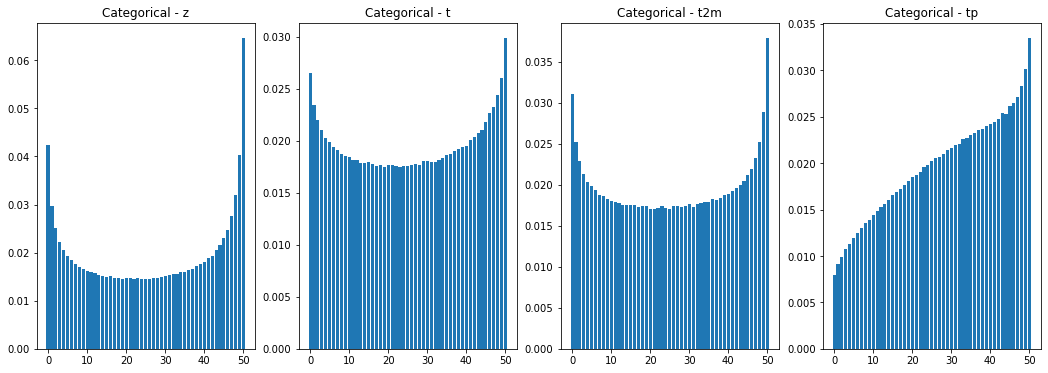

In [221]:
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
for j, v in enumerate(['z', 't', 't2m', 'tp']):
    r = ranks[v]
    axs[j].bar(np.arange(51), r[0])
    axs[j].set_title(f'Categorical - {v}')

## Quantile-bins categorical

In [ ]:
preds_cat_quant = xr.merge([
    xr.open_dataset(f'{pred_save_dir}/010-resnet_d3_z_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/011-resnet_d3_t_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/012-resnet_d3_t2m_3d_cat_quant.nc'),
    xr.open_dataset(f'{pred_save_dir}/013-resnet_d3_tp_3d_cat_quant.nc'),
]).isel(time=slice(0, None, 12))

In [ ]:
preds_cat_quant

In [ ]:
time = '2017-01-04T12:00:00'
preds_cat_quant.z.sel(time=time).isel(lat=8, lon=16).plot()
preds_cat_quant.tp.sel(time=time).isel(lat=8, lon=16).plot()

In [ ]:
# Adjust bin edges and mid_points
for v in ['z', 't', 't2m', 'tp']:
    preds_cat_quant[v].bin_edges[0] = valid_diff[v].min().values
    preds_cat_quant[v].bin_edges[-1] = valid_diff[v].max().values
    preds_cat_quant[v].mid_points[:] = (preds_cat_quant[v].bin_edges[1:] +  preds_cat_quant[v].bin_edges[:-1])/2

In [ ]:
preds_cat_quant.tp.isel(time=0).plot()